# Nuestras Caras

Este código implementa una técnica de reconocimiento facial conocida como "Eigenfaces". 

La idea básica detrás de Eigenfaces es representar las caras de un conjunto de datos de entrenamiento en un espacio de características de dimensionalidad reducida utilizando el análisis de componentes principales (PCA). 

Luego, se implementa el algoritmo de backpropagation para diferenciar las caras de cada una de las personas.

DEPENDENCIAS NECESARIAS:

Previo a ejecutar la notebook deben ser instaladas las siguientes dependencias:
* pip install opencv-python
* pip install pandas
* pip install matplotlib
* pip install scikit-learn
* pip install cv2
* pip install face_recognition

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from photo_30x30 import cortar_imagenes     # Función para recortar imagenes y pasar a grises
from pixels import intensidad_pixels    # Función para obtener la intensidad de los pixeles
import perceptrones as per        # Script con backpropagation

### Ajuste de imágenes

En primer lugar tenemos que reconocer el rostro en cada foto y aplicar las siguientes transformaciones:\
i. Recortar la imagen para que solo el rostro sea visible.\
ii. Reducir a 30x30 pixeles.\
iii. Pasar a escala de grises (0-255).\

Esta operación solo debe realizarse una vez ya que las imágenes serán guardadas en una carpeta.

In [2]:
#********************************************************************************************************************
#                    CORTE DE LAS FOTOS Y CAMBIO DE ESCALA DE GRISES MEDIANTE PHOTO_30X30.PY
#********************************************************************************************************************
# Definimos donde se encuentran las fotos crudas y donde iran las grises 30x30
folder_name_raw = "input"
folder_name_output = "output"


# Cortar las fotos y cambiar a escala de grises
# cortar_imagenes(folder_name_raw, folder_name_output)


### Conversión de imágen a array de intensidad (0-255)

El siguiente paso será pasar las imágenes a una matriz numérica que tenga toda la información de ellas.

Cada fila corresponde a una imágen distinta y cada columna corresponde a la intensidad de uno de los pixels\
 (de 0 para negros a 255 para blancos).

Por otro lado, los nombres de la persona en la imágen también son extraídos.

In [3]:
#********************************************************************************************************************
#                    OBTENCION DE LOS VALORES DE LOS PIXELES DE LAS FOTOS MEDIANTE PIXELS.PY
#********************************************************************************************************************
# Guardo la info de las fotos en un dataframe
folder_path_output = os.path.join(os.getcwd(), folder_name_output)
data_fotos = intensidad_pixels(folder_path_output)

# Get the file names
file_names = data_fotos.iloc[:, 0]

# Tomo los nombres de cada persona
people_names = [name.split("-")[0] for name in file_names]

# Tomo las escalas de grises y divido por 255 para normalizar
greyscale_values = data_fotos.iloc[:, 1:].values/255.0



### División del data set en training y testing subsets

Separamos el data set en un 80% para el entrenamiento y el 20% restante para el testing del mismo.

También pasamos los array de caracteres con los nombres a arrays binarios, que serán los que ingresen al algoritmo de backpropagation.

In [4]:
#********************************************************************************************************************
# Separamos los data sets en training y test
#********************************************************************************************************************
# Mediante el parametro "stratify" nos aseguramos que se tomen todos los nombres
X_train, X_test, nombres_y_train, nombres_y_test = train_test_split(greyscale_values, people_names, test_size=0.2, random_state=42, stratify=people_names)

# Transformo los nombres a números (0-1) usando label binarizer
y_train = LabelBinarizer().fit_transform(nombres_y_train)
y_test = LabelBinarizer().fit_transform(nombres_y_test)

#********************************************************************************************************************

In [5]:
# Dimensiones del array
people_names = np.array(people_names)
people_names.shape

greyscale_values = np.array(greyscale_values)
greyscale_values.shape


(226, 900)

### Creamos la cara promedio

Text(0.5, 1.0, 'Cara Promedio')

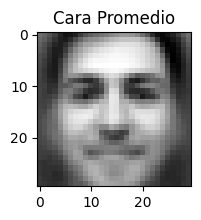

In [6]:
# obtiene y mustra la cara promedio
cara_promedio = np.mean(greyscale_values, axis=0)
cara_promedio.shape
plt.figure(figsize=(3, 2))
plt.imshow(cara_promedio.reshape(30,30),cmap="gray")
plt.title('Cara Promedio')

### PCA

Realizamos la reducción en la dimensionalidad mediante la técnica de componentes principales.

Debido a que las imágenes tienen 30x30 pixeles, originalmente son de 900 dimensiones. Vamos a reducirlo a 60 componentes.

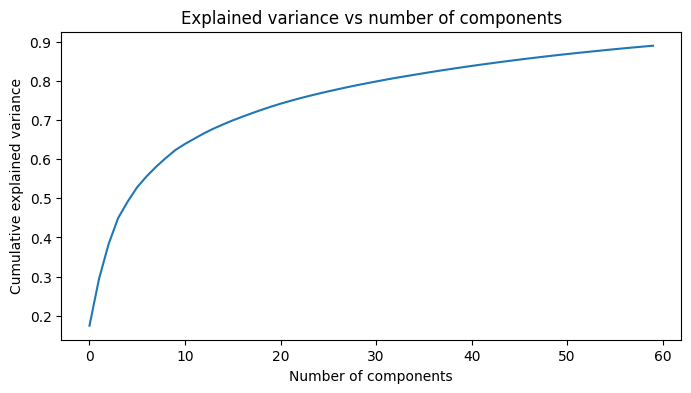

In [7]:
#********************************************************************************************************************
#                    PCA
#********************************************************************************************************************
# Se aplica PCA a las imagenes
# IMPORTANTE! al aumentar el nro de componentes tambien aumenta la precision en la comparacion de imagenes para la clasificacion al final de la notebook!
# Tiene sentido porque aumento el porcentaje de variabilidad explicada por las componentes, acercandome mas a la realidad
n_pca = 60
pca = PCA(n_components=n_pca).fit(X_train)
X_train_pca = pca.fit_transform(X_train)

eigenfaces = pca.components_
varianza_explicada = pca.explained_variance_ratio_

# plot explained variance (grafico continuo)
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(varianza_explicada))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Explained variance vs number of components')
plt.show()


Se observa que con aproximadamente 40 CP explicamos el 80% de la varianza. Y con 60 CP, nos acercamos al 90%.

### Eigenfaces

Estas imágenes muestran la variabilidad explicada por cada componentes principal.

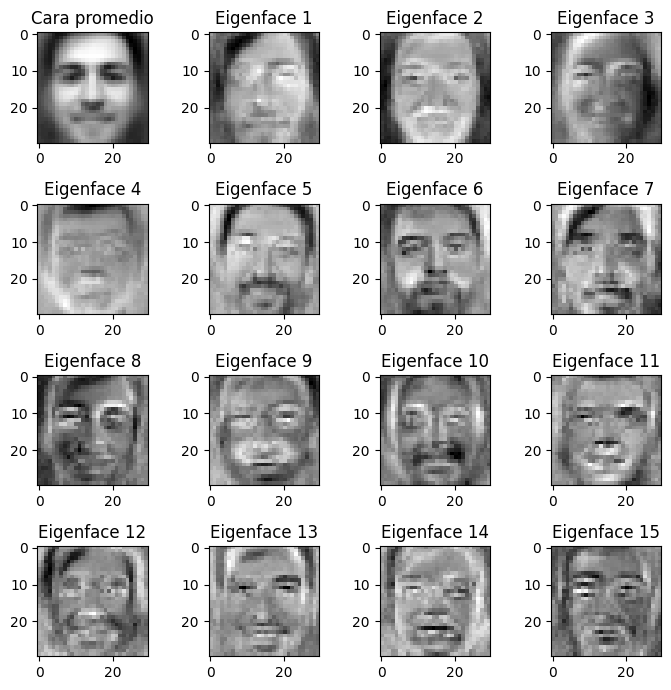

In [8]:
#********************************************************************************************************************
#                    GRAFICO DE LAS PRIMERAS 15 EIGENFACES
#********************************************************************************************************************

fig, ax = plt.subplots(4, 4, figsize=(7, 7))

ax[0, 0].imshow(cara_promedio.reshape(30,30), cmap="gray")
ax[0, 0].set_title("Cara promedio")

for i in range(0,15): # primeras 15 pca
    ax[(i+1) // 4, (i+1) % 4].imshow(eigenfaces[i].reshape(30,30), cmap="gray")
    ax[(i+1) // 4, (i+1) % 4].set_title(f"Eigenface {i+1}")

#plot dimensions
plt.tight_layout()
plt.show()

### Entrenamiento de la red neuronal con backpropagation
Comienza inicializando las matrices de pesos de manera aleatoria y realizando la propagación hacia adelante para obtener las salidas de la red. Luego, se calcula el error promedio y se inicia un bucle de entrenamiento que continúa hasta que se cumpla un criterio de convergencia o se alcance el límite de épocas. En cada iteración, se realiza la propagación hacia adelante y hacia atrás para ajustar los pesos mediante la corrección de errores. El proceso se repite hasta que se alcance la convergencia o el límite de épocas, mostrando el número de época y el valor del error en cada iteración.

In [9]:
#********************************************************************************************************************
# AHORA TENEMOS QUE USAR EL BACKPROPAGATION 
#********************************************************************************************************************


In [10]:
'''
#DEJO ESTE BLOQUE COMO COMENTARIO YA QUE DEMORA MUCHO EN CORRER

# Evaluamos la mejor combinacion de neuronas en las capas ocultas 1 y 2 (DEMORA MUCHO!)

# Creo una lista vacia para ir guardando los resultados
resultados = []

# Creo tres loops: 
# uno para la cantidad de neuronas en la capa 1, 
# otro para la cantidad de neuronas en la capa 2,
# y otro para la cantidad de fotos del test set


for i in range(1,36):
    for j in range(1,36):
        start_time = time.time()
        red_neuronal = per.backpropagation_2_capas(X_train_pca, y_train, i, j, 2000, 1.0e-6, 0.3)
        pesos = red_neuronal[:6]
        aciertos = 0
        # tiempo de ejecucion
        tiempo = time.time() - start_time
        # epoch y error
        epoch = red_neuronal[-1]
        error = red_neuronal[-2]
        # Recorro las fotos del test set
        for k in range(0, len(y_test)):
            foto_prueba = X_test[k]
            foto_prueba_pca = pca.transform(foto_prueba.reshape(1, -1))
            prediccion = per.predecir_clase_2_capas(pesos, foto_prueba_pca)
            # Si la prediccion es correcta, suma 1 en aciertos
            if prediccion[-1] == np.where(y_test[k]==1)[0][0]:
                aciertos += 1
        # El porcentaje acertado
        aciertos_pct = round(aciertos/len(y_test)*100,2)
        # Imprime combinacion de neuronas y aciertos
        print(f"*** Neuronas en primera capa: {i} *** Neuronas en segunda capa: {j} >>> Aciertos: {aciertos} ({aciertos_pct}%)")
        print('')
        # Guarda los resultados de esta combinacion en la lista
        resultados.append((i, j, tiempo, epoch, error, aciertos, aciertos_pct))



#********************************************************************************************************************
# Tarda tanto en correr que guardo los resultados en un archivo externo

# Guardo los resultados en un dataframe
resultados_df = pd.DataFrame(resultados, columns=["Neuronas_1", "Neuronas_2", "Tiempo", "Epoch", "Error", "Aciertos", "Porcentaje_Aciertos"])

# Guardo el dataframe en un archivo csv
resultados_df.to_csv("test_backpropagation.csv", index=False)

'''

'\n#DEJO ESTE BLOQUE COMO COMENTARIO YA QUE DEMORA MUCHO EN CORRER\n\n# Evaluamos la mejor combinacion de neuronas en las capas ocultas 1 y 2 (DEMORA MUCHO!)\n\n# Creo una lista vacia para ir guardando los resultados\nresultados = []\n\n# Creo tres loops: \n# uno para la cantidad de neuronas en la capa 1, \n# otro para la cantidad de neuronas en la capa 2,\n# y otro para la cantidad de fotos del test set\n\n\nfor i in range(1,36):\n    for j in range(1,36):\n        start_time = time.time()\n        red_neuronal = per.backpropagation_2_capas(X_train_pca, y_train, i, j, 2000, 1.0e-6, 0.3)\n        pesos = red_neuronal[:6]\n        aciertos = 0\n        # tiempo de ejecucion\n        tiempo = time.time() - start_time\n        # epoch y error\n        epoch = red_neuronal[-1]\n        error = red_neuronal[-2]\n        # Recorro las fotos del test set\n        for k in range(0, len(y_test)):\n            foto_prueba = X_test[k]\n            foto_prueba_pca = pca.transform(foto_prueba.resha

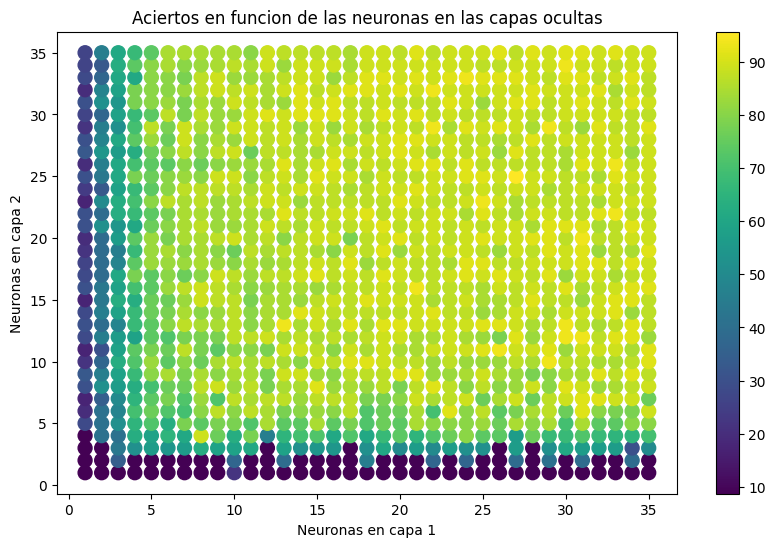

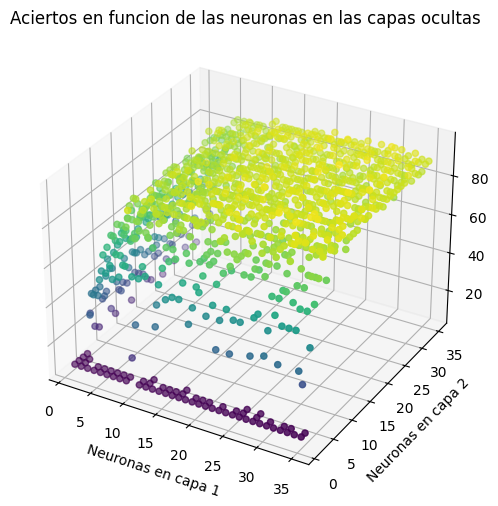

In [11]:
# Graficamos los resultados de la evaluacion de las neuronas en las capas ocultas
# Abrir csv
resultados = pd.read_csv("test_backpropagation.csv")

# Paso a numpy array
resultados = np.array(resultados)

# Tomos los porcentajes de aciertos
resultados_pct = resultados[:,6]

# Ploteo en un grafico 2D
plt.figure(figsize=(10, 6))
plt.scatter(resultados[:,0], resultados[:,1], c=resultados_pct, cmap='viridis', s=100)
plt.colorbar()
plt.xlabel('Neuronas en capa 1')
plt.ylabel('Neuronas en capa 2')
plt.title('Aciertos en funcion de las neuronas en las capas ocultas')
plt.show()

# Ploteo en un grafico 3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(resultados[:,0], resultados[:,1], resultados_pct, c=resultados_pct, cmap='viridis')
ax.set_xlabel('Neuronas en capa 1')
ax.set_ylabel('Neuronas en capa 2')
ax.set_zlabel('Aciertos (%)')
plt.title('Aciertos en funcion de las neuronas en las capas ocultas')
plt.show()

#********************************************************************************************************************





Se observa un crecimiento en el porcentaje de aciertos a medida que se incrementa la cantidad de neuronas en cada capa. Con 1 neurona en cualquiera de las dos capas, el porcentaje de acierto no supera el 25%.

También se observa que superando aproximadamente 7 u 8 neuronas en cualquiera de las dos capas no hay incrementos muy grandes.

Armamos un ranking para definir cual es la combinación que más aciertos obtiene.

In [12]:
# Armo un ranking de las 20 mejores combinaciones segun el porcentaje de aciertos

# Me quedo solo con los valores de cada capa y el porcentaje de aciertos
ranking = resultados[:,[0,1,6]]
# Ordeno de mayor a menor porcentaje de aciertos
ranking = ranking[ranking[:,2].argsort()[::-1]]
# Me quedo con las mejores
ranking = ranking[:20]
print(ranking)

# Nos quedamos con la mejor combinacion de neuronas en las capas ocultas
# Podemos elegir si quedarnos con muchas neuronas en cada capa o reducirlo un poco



[[27.   25.   95.65]
 [22.   29.   93.48]
 [13.   13.   93.48]
 [33.   26.   93.48]
 [22.   32.   93.48]
 [24.   33.   93.48]
 [25.   23.   93.48]
 [29.   10.   93.48]
 [26.   11.   93.48]
 [29.   29.   93.48]
 [31.   20.   93.48]
 [21.   16.   93.48]
 [31.   12.   93.48]
 [33.   22.   93.48]
 [30.   13.   93.48]
 [30.   12.   93.48]
 [30.   34.   93.48]
 [23.    6.   91.3 ]
 [24.   25.   91.3 ]
 [29.   11.   91.3 ]]


### El mejor modelo

Del ranking creado se ven varias combinaciones que resultan efectivas (porcentaje de acierto superior al 90%). Decidimos quedarnos con la combinación que menos neuronas use ya que será el modelo más sencillo.

Elegimos quedarnos con 13 neuronas en cada capa.

In [13]:
#********************************************************************************************************************
# El mejor modelo
#********************************************************************************************************************
neuronas_1_best = 13
neuronas_2_best = 13

# Entrenamos el mejor modelo
red_neuronal_best = per.backpropagation_2_capas(X_train_pca, y_train, neuronas_1_best, neuronas_2_best, 2000, 1.0e-6, 0.3)
pesos_best = red_neuronal_best[:6]

#********************************************************************************************************************
# Evaluamos el mejor modelo

aciertos = 0
# Recorro las fotos del test set
for k in range(0, len(y_test)):
    status = "error"
    foto_prueba = X_test[k]
    foto_prueba_pca = pca.transform(foto_prueba.reshape(1, -1))
    prediccion = per.predecir_clase_2_capas(pesos_best, foto_prueba_pca)
    # Si la prediccion es correcta, suma 1 en aciertos
    if prediccion[-1] == np.where(y_test[k]==1)[0][0]:
        aciertos += 1
        status = "OK"
    print(f"Prediccion: {nombres_y_test[prediccion[-1]]} - Real: {nombres_y_test[np.where(y_test[k]==1)[0][0]]} - {status}")


# El porcentaje acertado
aciertos_pct = round(aciertos/len(y_test)*100,2)
# Imprime combinacion de neuronas y aciertos
print(f">>> Aciertos: {aciertos} ({aciertos_pct}%)")

Error inicial: 0.3184606743175595
Epoch: 264, Error: 0.0004892595257599462
Prediccion: Paola - Real: Paola - OK
Prediccion: Noelia - Real: Noelia - OK
Prediccion: Federico R - Real: Federico R - OK
Prediccion: Federico G - Real: Federico G - OK
Prediccion: Matias - Real: Matias - OK
Prediccion: Victorio - Real: Victorio - OK
Prediccion: Franco A - Real: Franco A - OK
Prediccion: Federico G - Real: Federico G - OK
Prediccion: Matias - Real: Matias - OK
Prediccion: Juan - Real: Juan - OK
Prediccion: Noelia - Real: Noelia - OK
Prediccion: Federico G - Real: Federico G - OK
Prediccion: Paola - Real: Paola - OK
Prediccion: Paola - Real: Paola - OK
Prediccion: Joaquin - Real: Joaquin - OK
Prediccion: Paola - Real: Paola - OK
Prediccion: Paola - Real: Paola - OK
Prediccion: Matias - Real: Matias - OK
Prediccion: Noelia - Real: Federico G - error
Prediccion: Gustavo - Real: Gustavo - OK
Prediccion: Noelia - Real: Juan - error
Prediccion: Victorio - Real: Victorio - OK
Prediccion: Paola - Real:

## Propuestas de mejora

### Prueba de mejora N° 1: Quitar las primeras 3 CP

Una propuesta de mejora es quitar las primeras 3 componentes principales y analizar si el modelo resulta más efectivo o rápido.

La idea detrás de esta propuesta es dejar de considerar las componentes que reflejen aspectos comunes a todas las caras, como por ejemplo la iluminiación.

In [14]:
# Prueba: Quitamos las primeras 3 CP

# Retiro las primeras 3 componentes
X_menos_3 = X_train_pca[:, 3:]
print(X_menos_3.shape)

# Red neuronal con las primeras 3 componentes quitadas
start_time = time.time()
red_neuronal_menos_3 = per.backpropagation_2_capas(X_menos_3, y_train, neuronas_1_best, neuronas_2_best, 2000, 1.0e-6, 0.3)
pesos_menos_3 = red_neuronal_menos_3[:6]

# mido el tiempo de entrenamiento
tiempo = time.time() - start_time

# Evaluamos el modelo
aciertos = 0
# Recorro las fotos del test set
for k in range(0, len(y_test)):
    foto_prueba = X_test[k]
    foto_prueba_pca = pca.transform(foto_prueba.reshape(1, -1))
    foto_prueba_pca = foto_prueba_pca[:, 3:]
    prediccion = per.predecir_clase_2_capas(pesos_menos_3, foto_prueba_pca)
    # Si la prediccion es correcta, suma 1 en aciertos
    if prediccion[-1] == np.where(y_test[k]==1)[0][0]:
        aciertos += 1
    
    
# El porcentaje acertado
aciertos_pct = round(aciertos/len(y_test)*100,2)
# Imprime combinacion de neuronas y aciertos
print(f">>> Aciertos: {aciertos} ({aciertos_pct}%) - Tiempo: {tiempo} segundos")



(180, 57)
Error inicial: 0.2931544092253797
Epoch: 275, Error: 0.00017747220083470195
>>> Aciertos: 40 (86.96%) - Tiempo: 25.330873489379883 segundos


### Propuesta de mejora N°2: Restar la cara promedio

Del mismo modo que con la propuesta N°1, ahora vamos a tomar los vectores de cada imágen del training set y restarle las CP de la cara promedio.

In [15]:
# Prueba 2: Restamos la cara promedio

X_menos_promedio = X_train_pca - pca.transform(cara_promedio.reshape(1, -1))
print(X_menos_promedio.shape)

# Red neuronal con la cara promedio restada
start_time = time.time()
red_neuronal_menos_promedio = per.backpropagation_2_capas(X_menos_promedio, y_train, neuronas_1_best, neuronas_2_best, 2000, 1.0e-6, 0.3)
pesos_menos_promedio = red_neuronal_menos_promedio[:6]

# mido el tiempo de entrenamiento
tiempo = time.time() - start_time

# Evaluamos el modelo
aciertos = 0

# Recorro las fotos del test set
for k in range(0, len(y_test)):
    foto_prueba = X_test[k]
    foto_prueba_pca = pca.transform(foto_prueba.reshape(1, -1))
    foto_prueba_pca = foto_prueba_pca - pca.transform(cara_promedio.reshape(1, -1))
    prediccion = per.predecir_clase_2_capas(pesos_menos_promedio, foto_prueba_pca)
    # Si la prediccion es correcta, suma 1 en aciertos
    if prediccion[-1] == np.where(y_test[k]==1)[0][0]:
        aciertos += 1


# El porcentaje acertado
aciertos_pct = round(aciertos/len(y_test)*100,2)
# Imprime combinacion de neuronas y aciertos
print(f">>> Aciertos: {aciertos} ({aciertos_pct}%) - Tiempo: {tiempo} segundos")



(180, 60)
Error inicial: 0.3184398620270073
Epoch: 264, Error: 0.0004892257900523149
>>> Aciertos: 42 (91.3%) - Tiempo: 24.45441436767578 segundos


### Evaluamos las propuestas de mejora

Para esto no vamos a quedarnos con la misma cantidad de neuronas en la primera y segunda capas ocultas ya que podría existir una combinación más efectiva.

Realizamos la evaluación de combinación de neuronas nuevamente, preo lo reducimos de un máximo de 35 neuronas a 20 neuronas en cada capa ya que el proceso demora demasiado.

In [16]:
'''
# DEJO ESTO COMO COMENTARIO PORQUE TARDA MUCHO EN CORRER


# Evaluo la mejor combinacion pero usando el modelo sin la cara promedio


# Creo una lista vacia para ir guardando los resultados
resultados_menos_promedio = []

# Creo tres loops: 
# uno para la cantidad de neuronas en la capa 1, 
# otro para la cantidad de neuronas en la capa 2,
# y otro para la cantidad de fotos del test set


for i in range(1,21):
    for j in range(1,21):
        start_time = time.time()
        red_neuronal = per.backpropagation_2_capas(X_menos_promedio, y_train, i, j, 2000, 1.0e-6, 0.3)
        pesos = red_neuronal[:6]
        aciertos = 0
        # tiempo de ejecucion
        tiempo = time.time() - start_time
        # epoch y error
        epoch = red_neuronal[-1]
        error = red_neuronal[-2]
        # Recorro las fotos del test set
        for k in range(0, len(y_test)):
            foto_prueba = X_test[k]
            foto_prueba_pca = pca.transform(foto_prueba.reshape(1, -1))
            prediccion = per.predecir_clase_2_capas(pesos, foto_prueba_pca)
            # Si la prediccion es correcta, suma 1 en aciertos
            if prediccion[-1] == np.where(y_test[k]==1)[0][0]:
                aciertos += 1
        # El porcentaje acertado
        aciertos_pct = round(aciertos/len(y_test)*100,2)
        # Imprime combinacion de neuronas y aciertos
        print(f"*** Neuronas en primera capa: {i} *** Neuronas en segunda capa: {j} >>> Aciertos: {aciertos} ({aciertos_pct}%)")
        print('')
        # Guarda los resultados de esta combinacion en la lista
        resultados_menos_promedio.append((i, j, tiempo, epoch, error, aciertos, aciertos_pct))



# Tarda tanto en correr que guardo los resultados en un archivo externo

# Guardo los resultados en un dataframe
resultados_menos_promedio_df = pd.DataFrame(resultados_menos_promedio, columns=["Neuronas_1", "Neuronas_2", "Tiempo", "Epoch", "Error", "Aciertos", "Porcentaje_Aciertos"])

# Guardo el dataframe en un archivo csv
resultados_menos_promedio_df.to_csv("test_backpropagation_menos_promedio.csv", index=False)

#********************************************************************************************************************

# Tambien armo el test para la mejor combinacion de neuronas pero quitando las primeras 3 componentes

# Creo una lista vacia para ir guardando los resultados
resultados_menos_3 = []

# Creo tres loops:
# uno para la cantidad de neuronas en la capa 1,
# otro para la cantidad de neuronas en la capa 2,
# y otro para la cantidad de fotos del test set


for i in range(1,21):
    for j in range(1,21):
        start_time = time.time()
        red_neuronal = per.backpropagation_2_capas(X_menos_3, y_train, i, j, 2000, 1.0e-6, 0.3)
        pesos = red_neuronal[:6]
        aciertos = 0
        # tiempo de ejecucion
        tiempo = time.time() - start_time
        # epoch y error
        epoch = red_neuronal[-1]
        error = red_neuronal[-2]
        # Recorro las fotos del test set
        for k in range(0, len(y_test)):
            foto_prueba = X_test[k]
            foto_prueba_pca = pca.transform(foto_prueba.reshape(1, -1))
            foto_prueba_pca = foto_prueba_pca[:, 3:]
            prediccion = per.predecir_clase_2_capas(pesos, foto_prueba_pca)
            # Si la prediccion es correcta, suma 1 en aciertos
            if prediccion[-1] == np.where(y_test[k]==1)[0][0]:
                aciertos += 1
        # El porcentaje acertado
        aciertos_pct = round(aciertos/len(y_test)*100,2)
        # Imprime combinacion de neuronas y aciertos
        print(f"*** Neuronas en primera capa: {i} *** Neuronas en segunda capa: {j} >>> Aciertos: {aciertos} ({aciertos_pct}%)")
        print('')
        # Guarda los resultados de esta combinacion en la lista
        resultados_menos_3.append((i, j, tiempo, epoch, error, aciertos, aciertos_pct))
        
# Guardo los resultados en un dataframe
resultados_menos_3_df = pd.DataFrame(resultados_menos_3, columns=["Neuronas_1", "Neuronas_2", "Tiempo", "Epoch", "Error", "Aciertos", "Porcentaje_Aciertos"])

# Guardo el dataframe en un archivo csv
resultados_menos_3_df.to_csv("test_backpropagation_menos_3.csv", index=False)

'''

'\n# DEJO ESTO COMO COMENTARIO PORQUE TARDA MUCHO EN CORRER\n\n\n# Evaluo la mejor combinacion pero usando el modelo sin la cara promedio\n\n\n# Creo una lista vacia para ir guardando los resultados\nresultados_menos_promedio = []\n\n# Creo tres loops: \n# uno para la cantidad de neuronas en la capa 1, \n# otro para la cantidad de neuronas en la capa 2,\n# y otro para la cantidad de fotos del test set\n\n\nfor i in range(1,21):\n    for j in range(1,21):\n        start_time = time.time()\n        red_neuronal = per.backpropagation_2_capas(X_menos_promedio, y_train, i, j, 2000, 1.0e-6, 0.3)\n        pesos = red_neuronal[:6]\n        aciertos = 0\n        # tiempo de ejecucion\n        tiempo = time.time() - start_time\n        # epoch y error\n        epoch = red_neuronal[-1]\n        error = red_neuronal[-2]\n        # Recorro las fotos del test set\n        for k in range(0, len(y_test)):\n            foto_prueba = X_test[k]\n            foto_prueba_pca = pca.transform(foto_prueba.res

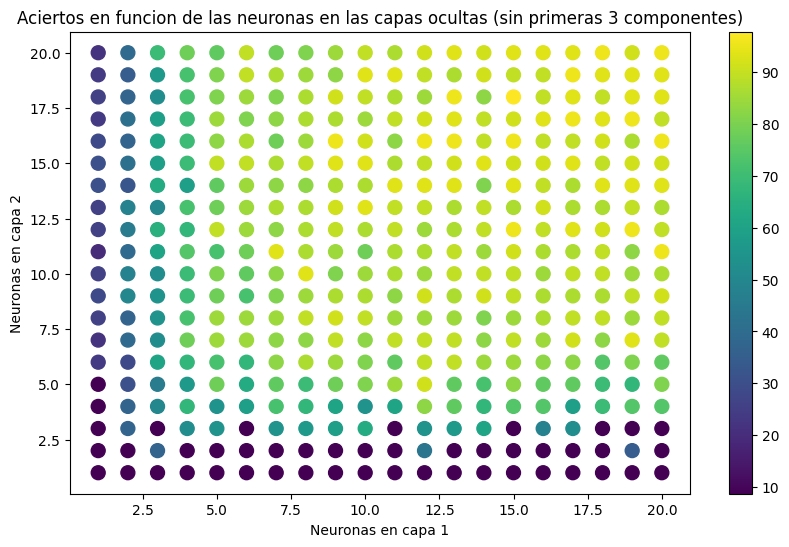

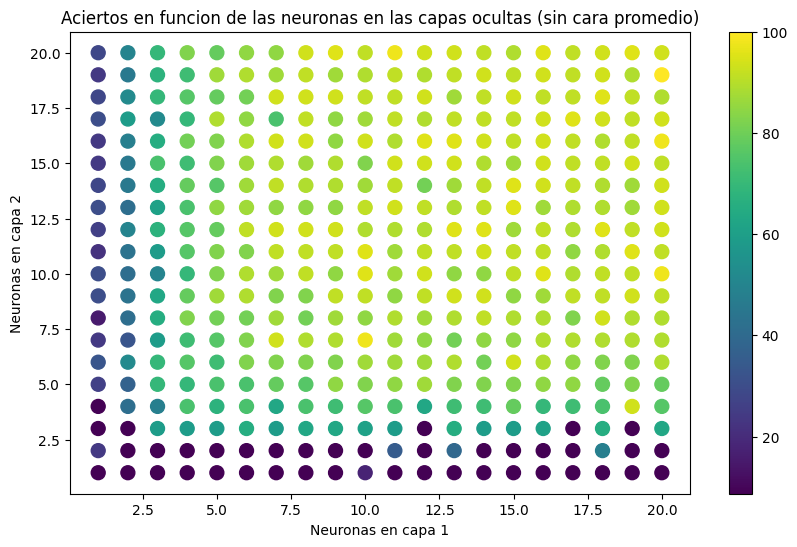

[[15.   18.   97.83]
 [20.   20.   95.65]
 [19.   17.   95.65]
 [17.   19.   95.65]
 [17.   17.   95.65]
 [18.   20.   95.65]
 [13.   16.   95.65]
 [13.   18.   95.65]
 [ 9.   16.   95.65]
 [12.   16.   95.65]
 [19.   12.   95.65]
 [20.   11.   95.65]
 [15.   16.   95.65]
 [20.   16.   95.65]
 [15.   12.   95.65]
 [10.   15.   93.48]
 [17.   12.   93.48]
 [10.   19.   93.48]
 [20.   19.   93.48]
 [18.   19.   93.48]]
[[ 20.    19.   100.  ]
 [ 11.    20.    97.83]
 [ 20.    16.    97.83]
 [ 10.     7.    97.83]
 [ 20.    10.    97.83]
 [ 18.    12.    95.65]
 [ 14.    12.    95.65]
 [ 10.    11.    95.65]
 [ 10.    10.    95.65]
 [  9.    20.    95.65]
 [ 19.    11.    95.65]
 [ 12.    16.    95.65]
 [ 17.    17.    95.65]
 [ 13.    12.    95.65]
 [ 18.    18.    95.65]
 [ 19.    20.    95.65]
 [ 13.    16.    95.65]
 [ 15.    14.    95.65]
 [ 16.    20.    95.65]
 [ 15.    13.    95.65]]


In [17]:
# Graficamos los resultados de la evaluacion de las neuronas en las capas ocultas
# Abrir csv
resultados_menos_3 = pd.read_csv("test_backpropagation_menos_3.csv")
resultados_menos_promedio = pd.read_csv("test_backpropagation_menos_promedio.csv")

# Paso a numpy array
resultados_menos_3 = np.array(resultados_menos_3)
resultados_menos_promedio = np.array(resultados_menos_promedio)

# Tomos los porcentajes de aciertos
resultados_menos_3_pct = resultados_menos_3[:,6]
resultados_menos_promedio_pct = resultados_menos_promedio[:,6]

# Ploteo en un grafico 2D
plt.figure(figsize=(10, 6))
plt.scatter(resultados_menos_3[:,0], resultados_menos_3[:,1], c=resultados_menos_3_pct, cmap='viridis', s=100)
plt.colorbar()
plt.xlabel('Neuronas en capa 1')
plt.ylabel('Neuronas en capa 2')
plt.title('Aciertos en funcion de las neuronas en las capas ocultas (sin primeras 3 componentes)')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(resultados_menos_promedio[:,0], resultados_menos_promedio[:,1], c=resultados_menos_promedio_pct, cmap='viridis', s=100)
plt.colorbar()
plt.xlabel('Neuronas en capa 1')
plt.ylabel('Neuronas en capa 2')
plt.title('Aciertos en funcion de las neuronas en las capas ocultas (sin cara promedio)')
plt.show()

# Ranking de las mejores combinaciones
ranking_menos_3 = resultados_menos_3[:,[0,1,6]]
ranking_menos_promedio = resultados_menos_promedio[:,[0,1,6]]

# Ordeno de mayor a menor porcentaje de aciertos
ranking_menos_3 = ranking_menos_3[ranking_menos_3[:,2].argsort()[::-1]]
ranking_menos_promedio = ranking_menos_promedio[ranking_menos_promedio[:,2].argsort()[::-1]]

# Me quedo con las mejores
ranking_menos_3 = ranking_menos_3[:20]
ranking_menos_promedio = ranking_menos_promedio[:20]


print(ranking_menos_3)
print(ranking_menos_promedio)




Lo más significativo es el ranking de combinación de neuronas. Por un lado, vemos que la combinación de neuronas que era más efectiva anteriormente, se ve modifica para estos dos nuevos modelos.

Por otro lado, ambas propuestas de mejora resultaron con mayores porcentajes de aciertos que el modelo presentado previamente (aunque la mejora es marginal porque el % ya era alto).

Por último, la segunda propuesta de mejora (restando la cara promedio) llega a un sorprendente **100% de efectividad** con 20 y 19 neuronas en la primera y segunda capa, respectivamente.

## Predict

In [19]:
folder_name_raw_predict = "predict/nuevas_caras"
folder_name_output_predict = "predict/nuevas_caras_cortadas"

In [20]:
#cortar_imagenes(folder_name_raw_predict, folder_name_output_predict)

In [23]:
#********************************************************************************************************************
#                    OBTENCION DE LOS VALORES DE LOS PIXELES DE LAS FOTOS MEDIANTE PIXELS.PY
#********************************************************************************************************************
# Guardo la info de las fotos en un dataframe
folder_path_output_predict = os.path.join(os.getcwd(), folder_name_output_predict)
data_fotos_predict = intensidad_pixels(folder_path_output_predict)

# Get the file names
file_names_predict = data_fotos_predict.iloc[:, 0]

# Tomo los nombres de cada persona
people_names_predict = [name.split("-")[0] for name in file_names_predict]

# Tomo las escalas de grises y divido por 255 para normalizar
greyscale_values_predict = data_fotos_predict.iloc[:, 1:].values/255.0



In [67]:
X_new, nombres_y_new = greyscale_values_predict, people_names_predict

# Transformo los nombres a números (0-1) usando label binarizer
lb = LabelBinarizer()
y_new = lb.fit_transform(nombres_y_new)
y_new_labels = lb.classes_

# puede que sea necesario hacer lo mismo con y_train_labels!


In [32]:
# Primero ajustamos modelo seleccionado
X_menos_promedio = X_train_pca - pca.transform(cara_promedio.reshape(1, -1))
red_neuronal_menos_promedio = per.backpropagation_2_capas(X_menos_promedio, y_train, 20, 19, 2000, 1.0e-6, 0.3)
pesos_menos_promedio = red_neuronal_menos_promedio[:6]

Error inicial: 0.27445771280188946
Epoch: 216, Error: 0.0004625248098748019


In [44]:
# VER....
# Obtenemos las predicciones
# Evaluamos el modelo
aciertos = 0

# Recorro las fotos del test set
for k in range(0, len(y_new)):
    foto_prueba = X_new[k]
    foto_prueba_pca = pca.transform(foto_prueba.reshape(1, -1))
    foto_prueba_pca = foto_prueba_pca - pca.transform(cara_promedio.reshape(1, -1))
    prediccion = per.predecir_clase_2_capas(pesos_menos_promedio, foto_prueba_pca)
    # Si la prediccion es correcta, suma 1 en aciertos
    if prediccion[-1] == np.where(y_new[k]==1)[0][0]:
        aciertos += 1
        
# El porcentaje acertado
aciertos_pct = round(aciertos/len(y_new)*100,2)

# Imprime combinacion de neuronas y aciertos
print(f">>> Aciertos: {aciertos} ({aciertos_pct}%) - Tiempo: {tiempo} segundos")

>>> Aciertos: 1 (16.67%) - Tiempo: 24.45441436767578 segundos


In [54]:
# predecir primera fila (Fede G)
foto_prueba = X_new[0]
foto_prueba_pca = pca.transform(foto_prueba.reshape(1, -1))
foto_prueba_pca = foto_prueba_pca - pca.transform(cara_promedio.reshape(1, -1))
prediccion = per.predecir_clase_2_capas(pesos_menos_promedio, foto_prueba_pca)

In [56]:
np.set_printoptions(suppress=True)

In [57]:
# ver... creo que no estamos identificando bien el nombre de cada fila...
prediccion

(array([[0.00041158],
        [0.38142761],
        [0.00085611],
        [0.01552628],
        [0.00000062],
        [0.00000157],
        [0.00047221],
        [0.01554712],
        [0.00000795],
        [0.00007367],
        [0.00008359],
        [0.14856721],
        [0.00193558],
        [0.00004238],
        [0.00114748],
        [0.02626255],
        [0.01540811],
        [0.00229051]]),
 1)

In [64]:
# VER....
aciertos = 0
# Recorro las fotos del test set
for k in range(0, len(y_new)):
    status = "error"
    foto_prueba = X_new[k]
    foto_prueba_pca = pca.transform(foto_prueba.reshape(1, -1))
    foto_prueba_pca = foto_prueba_pca - pca.transform(cara_promedio.reshape(1, -1))
    prediccion = per.predecir_clase_2_capas(pesos_menos_promedio, foto_prueba_pca)
    # Si la prediccion es correcta, suma 1 en aciertos
    if nombres_y_test[prediccion[-1]] == nombres_y_new[k]:
        aciertos += 1
        status = "OK"
    # if prediccion[-1] == np.where(y_new[k]==1)[0][0]:
    #     aciertos += 1
    #     status = "OK"
    print(f"Prediccion: {nombres_y_test[prediccion[-1]]} - Real: {nombres_y_new[k]} - {status}")


# El porcentaje acertado
aciertos_pct = round(aciertos/len(y_new)*100,2)
# Imprime combinacion de neuronas y aciertos
print(f">>> Aciertos: {aciertos} ({aciertos_pct}%)")

Prediccion: Matias - Real: Federico G - error
Prediccion: Paola - Real: Federico R - error
Prediccion: Paola - Real: Federico R - error
Prediccion: Noelia - Real: Federico R - error
Prediccion: Paola - Real: Lautaro - error
Prediccion: Victorio - Real: Paola - error
>>> Aciertos: 0 (0.0%)
